In [1]:
%cd /mnt/i/Yuki/workspace/exercises/image_processing_100_knock/Gasyori100knock

/mnt/i/Yuki/workspace/exercises/image_processing_100_knock/Gasyori100knock


https://github.com/yoyoyo-yo/Gasyori100knock/tree/master/Question_71_80

# 準備

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
imori_img_path = 'Question_71_80/imori.jpg'
imori_img = cv2.imread(imori_img_path)

## OpenCV は BGR を採用しているので RGB に変換する
BGR を採用している理由は単なる歴史的経緯らしい

In [4]:
imori_img = imori_img[:, :, ::-1]

# Utility Function

In [5]:
def rgb_to_hsv(rgb):
    rgb = rgb.astype(np.float) / 255
    hsv = np.zeros_like(rgb)
    hsv[:, :, 1] = np.max(rgb, axis=2) - np.min(rgb, axis=2)
    hsv[:, :, 2] = np.max(rgb, axis=2)

    hsv[:, :, 0] = np.where(
        rgb[:, :, 2] == np.min(rgb, axis=2),
        60 * (rgb[:, :, 1] - rgb[:, :, 0]) / (hsv[:, :, 1] + 1e-18) + 60,
        hsv[:, :, 0],
    )
    hsv[:, :, 0] = np.where(
        rgb[:, :, 0] == np.min(rgb, axis=2),
        60 * (rgb[:, :, 2] - rgb[:, :, 1]) / (hsv[:, :, 1] + 1e-18) + 180,
        hsv[:, :, 0],
    )
    hsv[:, :, 0] = np.where(
        rgb[:, :, 1] == np.min(rgb, axis=2),
        60 * (rgb[:, :, 0] - rgb[:, :, 2]) / (hsv[:, :, 1] + 1e-18) + 300,
        hsv[:, :, 0],
    )

    hsv[:, :, 0] %= 360
    
    return hsv

In [6]:
def bi_linear(img, a):
    base = img.copy()
    ans = np.zeros((int(base.shape[0] * a), int(base.shape[1] * a)))
    for i in range(ans.shape[0]):
        for j in range(ans.shape[1]):
            base_i = int(np.floor(i / a))
            base_j = int(np.floor(j / a))

            for i0 in range(2):
                for j0 in range(2):
                    di = abs(1 - (i / a - base_i) - i0)
                    dj = abs(1 - (j / a - base_j) - j0)
                    target_i = max(min(base_i + i0, base.shape[0] - 1), 0)
                    target_j = max(min(base_j + j0, base.shape[1] - 1), 0)
                    ans[i, j] += di * dj * base[target_i, target_j]

    ans = ans.astype(np.uint8)
    
    return ans

In [7]:
def get_gray_scale(img):
    return img[:, :, 0] * 0.2126 + img[:, :, 1] * 0.7152 + img[:, :, 2] * 0.0722

# 問題

## Q.71. マスキング

In [8]:
result = imori_img.copy()
hsv = rgb_to_hsv(result)
h = hsv[:, :, 0]

mask = np.zeros_like(h).astype(np.uint8)
mask[(h >= 180) * (h <= 260)] = 1
result[mask == 1] = [0, 0, 0]

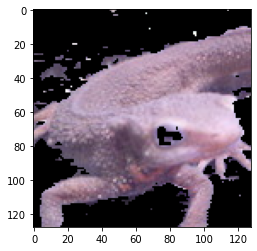

In [9]:
plt.imshow(result)

## Q.72. マスキング(カラートラッキング＋モルフォロジー)

In [10]:
def dilation(img):
    padded = np.pad(img, (1, 1), 'edge')
    filt = np.array([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0],
    ])
    
    ans = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if np.sum(padded[i:i+3, j:j+3] * filt) >= 255:
                ans[i, j] = 255

    return ans

def erosion(img):
    padded = np.pad(img, (1, 1), 'edge')
    filt = np.array([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0],
    ])
    
    ans = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if np.sum(padded[i:i+3, j:j+3] * filt) < 255 * 4:
                ans[i, j] = 0

    return ans

In [11]:
result = imori_img.copy()
hsv = rgb_to_hsv(result)
h = hsv[:, :, 0]

mask = np.zeros_like(h).astype(np.float32)
mask[(h > 180) * (h < 260)] = 255

N = 5
for _ in range(N):
    mask = dilation(mask)
for _ in range(N * 2):
    mask = erosion(mask)
for _ in range(N):
    mask = dilation(mask)

result[mask == 255] = [0, 0, 0]

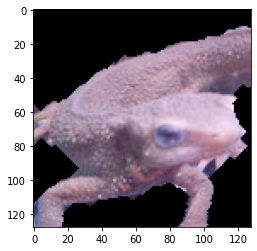

In [12]:
plt.imshow(result)

## Q.73. 縮小と拡大

In [13]:
base = get_gray_scale(imori_img)
result = bi_linear(bi_linear(base, 0.5), 2)

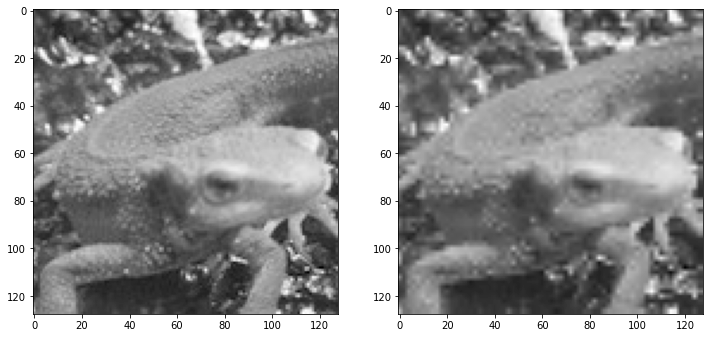

In [14]:
fig = plt.figure(figsize=(12, 24))
plt.subplot(1, 2, 1)
plt.imshow(base, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(result, cmap='gray')

## Q.74. ピラミッド差分による高周波成分の抽出

In [15]:
base = get_gray_scale(imori_img).astype(np.float32)
result = bi_linear(bi_linear(base, 0.5), 2).astype(np.float32)
diff = np.abs(result - base)
diff = (diff - np.min(diff)) / (np.max(diff) - np.min(diff)) * 255
diff = diff.astype(np.uint8)

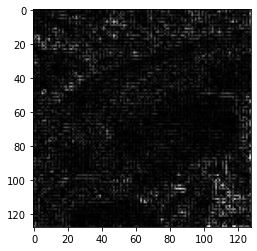

In [16]:
plt.imshow(diff, cmap='gray')

## Q.75. ガウシアンピラミッド

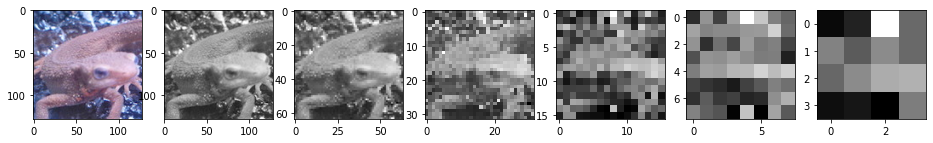

In [17]:
N = 5

gray = get_gray_scale(imori_img).astype(np.float32)

fig = plt.figure(figsize=(16, 16 * (N + 2)))
plt.subplot(1, N + 2, 1)
plt.imshow(imori_img, cmap='gray')
plt.subplot(1, N + 2, 2)
plt.imshow(gray, cmap='gray')

for i in range(N):
    gray = bi_linear(gray, 0.5)
    plt.subplot(1, N + 2, i + 3)
    plt.imshow(gray, cmap='gray')

## Q.76. 顕著性マップ

In [18]:
N = 5

gray = get_gray_scale(imori_img).astype(np.float32)
result = np.zeros_like(gray)

grays = []
grays.append(gray)
for i in range(N):
    gray = bi_linear(gray, 0.5)
    recover = gray.copy()
    for _ in range(i + 1):
        recover = bi_linear(recover, 2)
    grays.append(recover.astype(np.float32))

pairs = [(0,1), (0,3), (0,5), (1,4), (2,3), (3,5)]
for i, j in pairs:
    result += np.abs(grays[i] - grays[j])

result = (result - np.min(result)) / (np.max(result) - np.min(result)) * 255
result = result.astype(np.uint8)

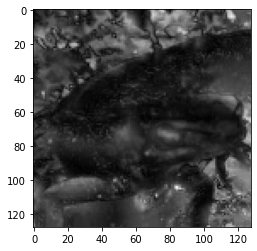

In [19]:
plt.imshow(result, cmap='gray')

## Q.77. ガボールフィルタ

In [20]:
def get_gabor_filter(K, s, g, l, p, A):
    gabor_filter = np.zeros((K, K))
    A_ = A / 180 * np.pi
    p_ = p / 180 * np.pi
    right = K // 2
    left = -(K - right - 1)

    for y in range(left, right + 1):
        for x in range(left, right + 1):
            x_ = np.cos(A_) * x + np.sin(A_) * y
            y_ = - np.sin(A_) * x + np.cos(A_) * y
            gabor_filter[y + left, x + left] = np.exp(-(x_ ** 2 + (g * y_) ** 2) / 2 / (s ** 2)) * np.cos(2 * np.pi * x_ / l + p_)

    gabor_filter /= np.sum(np.abs(gabor_filter))

    return gabor_filter

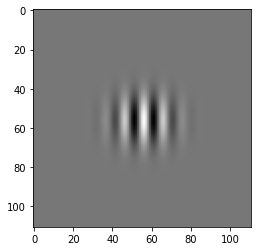

In [21]:
gabor_filter = get_gabor_filter(111, 10, 1.2, 10, 0, 0)
gabor_filter = (gabor_filter - np.min(gabor_filter)) / (np.max(gabor_filter) - np.min(gabor_filter)) * 255
gabor_filter = gabor_filter.astype(np.uint8)
plt.imshow(gabor_filter, cmap='gray')

## Q.78. ガボールフィルタの回転

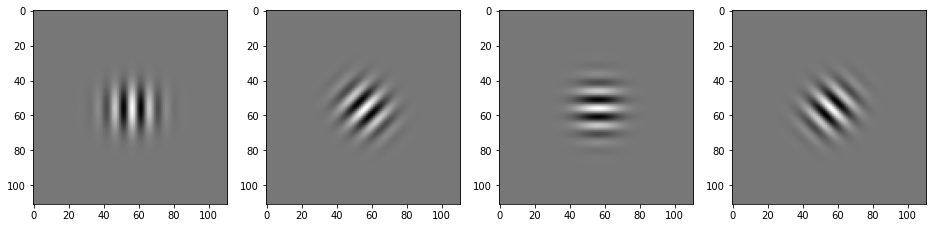

In [22]:
As = [0, 45, 90, 135]

fig = plt.figure(figsize=(16, 64))
for fig_id, A in enumerate(As):
    plt.subplot(1, len(As), fig_id + 1)
    gabor_filter = get_gabor_filter(111, 10, 1.2, 10, 0, A)
    gabor_filter = (gabor_filter - np.min(gabor_filter)) / (np.max(gabor_filter) - np.min(gabor_filter)) * 255
    gabor_filter = gabor_filter.astype(np.uint8)
    plt.imshow(gabor_filter, cmap='gray')

## Q.79. ガボールフィルタによるエッジ抽出

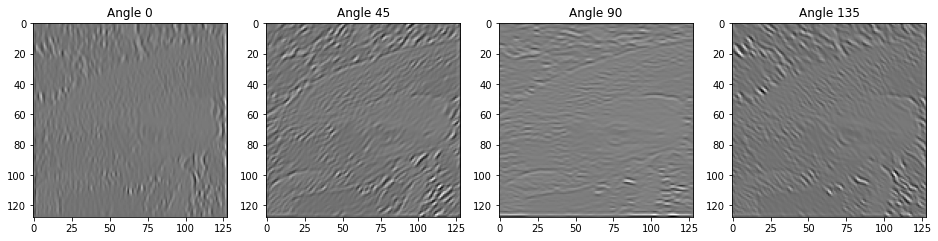

In [23]:
K = 11
left = K // 2
right = K - left - 1
As = [0, 45, 90, 135]
gray = get_gray_scale(imori_img).astype(np.float32)

results = []
fig = plt.figure(figsize=(16, 64))
for fig_id, A in enumerate(As):
    result = np.zeros_like(gray)
    padded = np.pad(gray, (left, right), 'constant')
    gabor_filter = get_gabor_filter(K, 1.5, 1.2, 3, 0, A)
    for i in range(gray.shape[0]):
        for j in range(gray.shape[1]):
            result[i, j] = np.sum(padded[i:i+K, j:j+K] * gabor_filter)

    result = (result - np.min(result)) / (np.max(result) - np.min(result)) * 255
    result = result.astype(np.uint8)
    results.append(result)

    plt.subplot(1, len(As), fig_id + 1)
    plt.title(f'Angle {A}')
    plt.imshow(result, cmap='gray')

## Q.80. ガボールフィルタによる特徴抽出

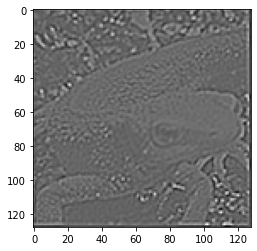

In [24]:
result = np.mean(results, axis=0)
plt.imshow(result, cmap='gray')